<a href="https://www.kaggle.com/code/rubanzasilva/s04e05-fastai?scriptVersionId=178621162" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Regression with a Flood Prediction Dataset

Playground Series - Season 4, Episode 5 where we are tasked with predicting the likelihood of floods in certain areas based off various factors.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flood-prediction-factors/flood.csv
/kaggle/input/playground-series-s4e5/sample_submission.csv
/kaggle/input/playground-series-s4e5/train.csv
/kaggle/input/playground-series-s4e5/test.csv


In [2]:
!pip install openfe

In [5]:
#hide
#! [ -e /content ]

#hide
#This imports and sets up everything you will need for this notebook
#
#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()

#from fastbook import *
#!pip install ucimlrepo
#from ucimlrepo import fetch_ucirepo

from fastai.tabular.all import *
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from numpy import random

from fastai.imports import *
np.set_printoptions(linewidth=130)


from pathlib import Path
import os


from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,r2_score
#from sklearn.metrics import root_mean_squared_error

import xgboost as xgb
from xgboost import plot_importance

import lightgbm as lgb

from catboost import CatBoostClassifier,CatBoostRegressor,Pool, metrics, cv

from ipywidgets import interact


matplotlib.rc('image', cmap='Greys')

#from fastkaggle import setup_comp

import optuna
from openfe import OpenFE, transform



In [6]:
!ls /kaggle/input/playground-series-s4e5

sample_submission.csv  test.csv  train.csv


In [7]:
#set_seed(42)

In [8]:
path = Path('/kaggle/input/playground-series-s4e5/')
path

Path('/kaggle/input/playground-series-s4e5')

After some experimentation, i noticed adding the original dataset helps the model generalize better and produces better results.

In [9]:
!ls /kaggle/input/flood-prediction-factors

flood.csv


In [10]:
train_df = pd.read_csv(path/'train.csv',index_col='id')
test_df = pd.read_csv(path/'test.csv',index_col='id')
sub_df = pd.read_csv(path/'sample_submission.csv',index_col='id')
#original_df = pd.read_csv('/kaggle/input/flood-prediction-factors/flood.csv')

In [11]:
train_df.shape,original_df.shape

((1117957, 21), (50000, 21))

In [12]:
train_df = pd.concat([train_df,original_df], axis=0)
train_df.shape

(1167957, 21)

In [29]:
train_df

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors,FloodProbability
openfe_index,,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3,0.445
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3,0.450
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3,0.530
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5,0.535
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5,0.415
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,3,7,4,7,5,9,4,6,10,4,4,7,3,8,8,6,1,5,4,2,0.535
49996,3,10,3,8,3,3,4,4,3,11,8,8,6,3,6,4,4,2,4,5,0.510
49997,4,4,5,7,2,1,4,5,6,7,7,4,6,4,1,5,1,6,4,3,0.430


# Open FE 

In [11]:
ofe = OpenFE()

In [12]:
#set n_jobs to be the actual cpu core count
CPU_COUNT = os.cpu_count()
n_jobs = CPU_COUNT
n_jobs

4

In [13]:
train_y = train_df['FloodProbability']
train_y

id
0          0.445
1          0.450
2          0.530
3          0.535
4          0.415
           ...  
1117952    0.495
1117953    0.480
1117954    0.485
1117955    0.495
1117956    0.560
Name: FloodProbability, Length: 1117957, dtype: float64

In [14]:
train_x = train_df.drop('FloodProbability',axis=1)
train_x

,MonsoonIntensity,TopographyDrainage,RiverManagement,Deforestation,Urbanization,ClimateChange,DamsQuality,Siltation,AgriculturalPractices,Encroachments,IneffectiveDisasterPreparedness,DrainageSystems,CoastalVulnerability,Landslides,Watersheds,DeterioratingInfrastructure,PopulationScore,WetlandLoss,InadequatePlanning,PoliticalFactors
id,,,,,,,,,,,,,,,,,,,,
0,5,8,5,8,6,4,4,3,3,4,2,5,3,3,5,4,7,5,7,3
1,6,7,4,4,8,8,3,5,4,6,9,7,2,0,3,5,3,3,4,3
2,6,5,6,7,3,7,1,5,4,5,6,7,3,7,5,6,8,2,3,3
3,3,4,6,5,4,8,4,7,6,8,5,2,4,7,4,4,6,5,7,5
4,5,3,2,6,4,4,3,3,3,3,5,2,2,6,6,4,1,2,3,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1117952,3,3,4,10,4,5,5,7,10,4,3,7,8,7,2,2,1,4,6,4
1117953,2,2,4,3,9,5,8,1,3,5,5,9,4,4,3,7,4,9,4,5
1117954,7,3,9,4,6,5,9,1,3,4,5,5,5,5,5,6,5,5,2,4


In [15]:
test_x = test_df
train_x.shape,train_y.shape,test_x.shape

((1117957, 20), (1117957,), (745305, 20))

Concating the original dataframe before running the OpenFE feature generation tool seems to result in a NameError.
This needs further investigation.

In [ ]:
%%time
features = ofe.fit(data=train_x, label=train_y, n_jobs=n_jobs)  # generate new features

The number of candidate features is 4360
Start stage I selection.


  0%|          | 0/16 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003783 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 13
[LightGBM] [Info] Number of data points in the train set: 111795, number of used features: 1
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might reso

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)




[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [ ]:
#features = ofe.fit(data=train_x, label=train_y, n_jobs=n_jobs)  # generate new features
%%time
train_x, test_x = transform(train_x, test_x, features, n_jobs=n_jobs) # transform the train and test data according to generated features.

## Dataset Subset

Since the dataset is large and takes a while to train, we can use a subset of the data for quick experimentation

### Using random subset

Using a random subset results in better and faster training

In [56]:
#train_subset = train_df.sample(n=50000,replace=False)
#test_subset = test_df.sample(n=30000,replace=False)

## Using Full Dataset

In [57]:
cont_names,cat_names = cont_cat_split(train_df, dep_var='FloodProbability')

In [58]:
splits = RandomSplitter(valid_pct=0.2)(range_of(train_df))

In [59]:
to = TabularPandas(train_df, procs=[Categorify, FillMissing,Normalize],
                   cat_names = cat_names,
                   cont_names = cont_names,
                   y_names='FloodProbability',
                   y_block=RegressionBlock(),
                   splits=splits)

In [60]:
X_train, y_train = to.train.xs, to.train.ys.values.ravel()
X_test, y_test = to.valid.xs, to.valid.ys.values.ravel()

In [61]:
dls = to.dataloaders(bs=64)
test_dl = dls.test_dl(test_df)

# Random Forest Baseline

We initially use a random forest as a baseline since it is a really simple model that doesnt break easily with small changes in the hyperparameters etc. 

We can also easily use this for explanability with features such as feature importance.

In [ ]:
%%time
rf = RandomForestRegressor(50, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

# Neural Network Baseline

SuggestedLRs(slide=0.009120108559727669, valley=0.0005754399462603033)

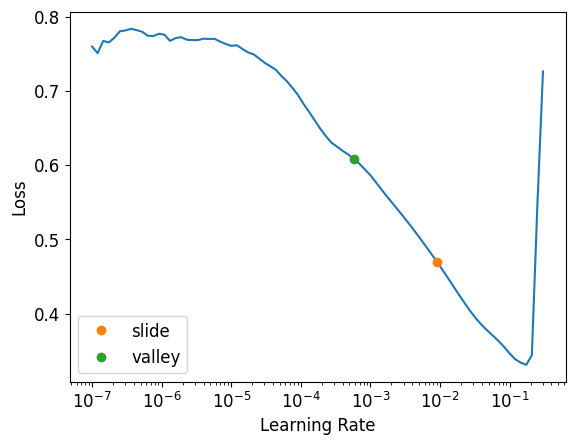

In [21]:
learn = tabular_learner(dls, metrics=R2Score())
learn.lr_find(suggest_funcs=(slide,valley))

In [18]:
%%time
learn.fit_one_cycle(12,lr_max=slice(learn.valley))


AttributeError: 'TabularModel' object has no attribute 'valley'

In [ ]:
%%time
#learn.fit_one_cycle(12,0.02)

In [19]:
dl = learn.dls.test_dl(test_df)

In [20]:
%%time
nn_preds = learn.get_preds(dl=dl)
nn_preds_x = learn.get_preds()[0]
a_preds, _ = learn.get_preds(dl=dl)
nn_preds_y = a_preds.squeeze(1)

CPU times: user 4min 29s, sys: 917 ms, total: 4min 30s
Wall time: 2min 17s


In [21]:
!ls

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


models


In [22]:
learn.export('models/fp_model.pkl')

In [ ]:
#learn.load('fp_model.pkl')

In [23]:
r2_score(y_test,nn_preds_x)

-110.07345504089412

# Neural Network Ensemble

In [ ]:
def ensemble():
    learn = tabular_learner(dls, metrics=RocAucMulti())
    with learn.no_bar(),learn.no_logging(): learn.fit(6, 0.02)
    return learn.get_preds(dl=dl)[0]

In [ ]:
learns = [ensemble() for _ in range(5)]

In [ ]:
ens_preds = torch.stack(learns).mean(0)

In [ ]:
nn_preds_x.shape,ens_preds.shape

In [ ]:
r2_score(y_test,nn_preds_x)

In [ ]:
target_preds = nn_preds[0]

In [ ]:
test_df['FloodProbability'] = target_preds

In [ ]:
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

In [ ]:
submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!rm submission.csv

In [ ]:
test_df['FloodProbability'] = target_preds
test_df.to_csv('submission.csv', columns=['FloodProbability'], index=True)

submission = pd.read_csv('submission.csv')
submission.head()

In [ ]:
!ls

# Random Forest Baseline

In [ ]:
rf = RandomForestRegressor(100, min_samples_leaf=3)
rf_model = rf.fit(X_train, y_train);

rf_preds = tensor(rf_model.predict(test_dl.xs))

rf_preds_x = tensor(rf_model.predict(X_test))

mse = mean_absolute_error(y_test, rf_preds_x)
rmse = np.sqrt(mse)

r2_score(y_test,rf_preds_x)

In [ ]:
!ls

# Optimize Params with Optuna

CatBoost - Optuna

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score

import optuna
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error

def objective_catboost(trial):
    params = {
        "iterations": 200,
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "depth": trial.suggest_int("depth", 1, 10),
        "random_strength": trial.suggest_int("random_strength", 1, 10),
    }
    model = CatBoostRegressor(**params, silent=True)
    model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)
    cat_predictions = model.predict(X_test)
    r2score = r2_score(y_test, cat_predictions)
    return r2score


study_catboost = optuna.create_study(direction='minimize')
study_catboost.optimize(objective_catboost, n_trials=200)
print(study_catboost.best_params)

LightGBM - Optuna

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)
print(study_lgbm.best_params)

In [ ]:
%%time

def objective_lgbm(trial):
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }
    
    model = lgb.LGBMRegressor(**params,verbose=False)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)

In [41]:
# Function Optuna
def objective(trial):
    # Define parameters to be optimized
    params = {
            'num_leaves': trial.suggest_int('num_leaves', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0, log=True),
            'n_estimators': trial.suggest_int('n_estimators', 300, 1200),
            'subsample_for_bin': trial.suggest_int('subsample_for_bin', 20000, 300000),
            'min_child_samples': trial.suggest_int('min_child_samples', 20, 500),
            'reg_alpha': trial.suggest_float('reg_alpha', 1e-9, 10.0, log=True),
            'reg_lambda': trial.suggest_float('reg_lambda', 1e-9, 10.0, log=True),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
            'subsample': trial.suggest_float('subsample', 0.25, 1.0),
            'max_depth': trial.suggest_int('max_depth', 1, 15)
            }
    
    # Train the model
    model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity=-1)
    model.fit(X_train, y_train)
    
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score
    
   

# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Get the best parameters and best R^2 score
best_params = study.best_params
best_r2 = study.best_value

print("Best R^2 score:", best_r2)
print("Best parameters:", best_params)

[I 2024-05-12 09:05:42,925] A new study created in memory with name: no-name-f399b8af-6dc3-4ff0-a09c-1350d0b2e784
[W 2024-05-12 09:05:42,932] Trial 0 failed with parameters: {'num_leaves': 179, 'learning_rate': 0.21659520680758576, 'n_estimators': 833, 'subsample_for_bin': 285187, 'min_child_samples': 77, 'reg_alpha': 1.9220584655009895e-07, 'reg_lambda': 2.282066621320484, 'colsample_bytree': 0.543450771015672, 'subsample': 0.2824901576804602, 'max_depth': 14} because of the following error: NameError("name 'LGBMRegressor' is not defined").
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_33/2742465432.py", line 18, in objective
    model = LGBMRegressor(**params, objective='regression', random_state=0, device='gpu', verbosity=-1)
NameError: name 'LGBMRegressor' is not defined
[W 2024-05-12 09:05:42,934] Trial 0 failed with value None.


NameError: name 'LGBMRegressor' is not defined

XGBoost - Optuna

In [ ]:
def objective_xgboost(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(X_train, y_train)
    xgb_predictions = model.predict(X_test)
    rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
    return rmse

study_xgboost = optuna.create_study(direction='minimize')
study_xgboost.optimize(objective_xgboost, n_trials=150)
print(study_xgboost.best_params)

# CatBoost Baseline

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=2000, depth=9, learning_rate= 0.29776650862748444, random_strength=3)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

In [ ]:
print(study_catboost.best_params)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=1441, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(iterations=50=00, depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

In [ ]:
#with optuna params
cat_model = CatBoostRegressor(depth=1, learning_rate= 0.01000456241465664, random_strength=10)
cat_model = cat_model.fit(X_train, y_train, eval_set=(X_test, y_test), verbose=False)

#test set preds
cat_preds = tensor(cat_model.predict(test_dl.xs))

#validation set preds
cat_preds_x = tensor(cat_model.predict(X_test))

r2_score(y_test,cat_preds_x)

# Light GBM

optuna params

In [62]:
%%time

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=50)
print(study_lgbm.best_params)

[I 2024-05-12 11:54:39,407] A new study created in memory with name: no-name-04e0f595-7359-49ba-ada1-c7162d969a1c


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:54:58,442] Trial 0 finished with value: 0.6114839967272241 and parameters: {'num_leaves': 42, 'learning_rate': 0.045486785513172555, 'n_estimators': 102}. Best is trial 0 with value: 0.6114839967272241.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:55:21,738] Trial 1 finished with value: 0.7071079140732737 and parameters: {'num_leaves': 27, 'learning_rate': 0.05244458960849329, 'n_estimators': 144}. Best is trial 0 with value: 0.6114839967272241.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:55:44,415] Trial 2 finished with value: 0.26375987747794294 and parameters: {'num_leaves': 23, 'learning_rate': 0.011870478908592247, 'n_estimators': 129}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:56:12,010] Trial 3 finished with value: 0.8335969068975019 and parameters: {'num_leaves': 33, 'learning_rate': 0.1574480552908777, 'n_estimators': 180}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181874 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:56:34,141] Trial 4 finished with value: 0.8290584813723292 and parameters: {'num_leaves': 36, 'learning_rate': 0.1957906890067929, 'n_estimators': 145}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:56:51,830] Trial 5 finished with value: 0.466516749718088 and parameters: {'num_leaves': 28, 'learning_rate': 0.03165591633378158, 'n_estimators': 100}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178295 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:57:12,153] Trial 6 finished with value: 0.8286447297008745 and parameters: {'num_leaves': 38, 'learning_rate': 0.18266676814473587, 'n_estimators': 123}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:57:45,104] Trial 7 finished with value: 0.5355160720553056 and parameters: {'num_leaves': 28, 'learning_rate': 0.020484104011380226, 'n_estimators': 197}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:58:06,082] Trial 8 finished with value: 0.683976877921752 and parameters: {'num_leaves': 45, 'learning_rate': 0.05196641807694162, 'n_estimators': 114}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181388 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:58:26,544] Trial 9 finished with value: 0.5922210661794951 and parameters: {'num_leaves': 39, 'learning_rate': 0.0402935078366811, 'n_estimators': 110}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:58:53,669] Trial 10 finished with value: 0.3012063107212447 and parameters: {'num_leaves': 20, 'learning_rate': 0.011587243845383548, 'n_estimators': 164}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:59:20,755] Trial 11 finished with value: 0.28373334191182287 and parameters: {'num_leaves': 20, 'learning_rate': 0.01073746868328717, 'n_estimators': 164}. Best is trial 2 with value: 0.26375987747794294.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 11:59:42,877] Trial 12 finished with value: 0.2553102367638711 and parameters: {'num_leaves': 20, 'learning_rate': 0.011692371763880298, 'n_estimators': 132}. Best is trial 12 with value: 0.2553102367638711.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:00:05,550] Trial 13 finished with value: 0.35951905191836053 and parameters: {'num_leaves': 24, 'learning_rate': 0.017263589297440502, 'n_estimators': 131}. Best is trial 12 with value: 0.2553102367638711.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:00:29,613] Trial 14 finished with value: 0.824194463106489 and parameters: {'num_leaves': 50, 'learning_rate': 0.1095516965380895, 'n_estimators': 132}. Best is trial 12 with value: 0.2553102367638711.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177106 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:00:57,800] Trial 15 finished with value: 0.48902860383753444 and parameters: {'num_leaves': 32, 'learning_rate': 0.020831553663667773, 'n_estimators': 158}. Best is trial 12 with value: 0.2553102367638711.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:01:18,320] Trial 16 finished with value: 0.781201551114702 and parameters: {'num_leaves': 24, 'learning_rate': 0.08468302507301204, 'n_estimators': 134}. Best is trial 12 with value: 0.2553102367638711.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:01:39,313] Trial 17 finished with value: 0.3001211330002288 and parameters: {'num_leaves': 23, 'learning_rate': 0.01488840407295219, 'n_estimators': 121}. Best is trial 12 with value: 0.2553102367638711.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:02:04,814] Trial 18 finished with value: 0.5514678556143686 and parameters: {'num_leaves': 30, 'learning_rate': 0.028153808633801267, 'n_estimators': 148}. Best is trial 12 with value: 0.2553102367638711.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:02:28,813] Trial 19 finished with value: 0.2505957885289113 and parameters: {'num_leaves': 22, 'learning_rate': 0.010401723452062816, 'n_estimators': 140}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174150 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:02:54,847] Trial 20 finished with value: 0.8040920821636002 and parameters: {'num_leaves': 20, 'learning_rate': 0.0788730486574496, 'n_estimators': 182}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176378 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:03:19,699] Trial 21 finished with value: 0.25229072762556737 and parameters: {'num_leaves': 24, 'learning_rate': 0.010138507848769577, 'n_estimators': 141}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:03:44,437] Trial 22 finished with value: 0.3256952519985786 and parameters: {'num_leaves': 26, 'learning_rate': 0.013767043118912348, 'n_estimators': 140}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177945 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:04:10,894] Trial 23 finished with value: 0.2726675673628305 and parameters: {'num_leaves': 22, 'learning_rate': 0.010435191402023841, 'n_estimators': 155}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179596 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:04:28,219] Trial 24 finished with value: 0.8218804021178974 and parameters: {'num_leaves': 25, 'learning_rate': 0.2889187730914561, 'n_estimators': 139}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176495 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:04:49,736] Trial 25 finished with value: 0.45271609560580817 and parameters: {'num_leaves': 30, 'learning_rate': 0.02440924807951329, 'n_estimators': 121}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:05:15,142] Trial 26 finished with value: 0.371899716731512 and parameters: {'num_leaves': 22, 'learning_rate': 0.015949261935197648, 'n_estimators': 153}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:05:45,602] Trial 27 finished with value: 0.469868113118905 and parameters: {'num_leaves': 30, 'learning_rate': 0.01804254762104127, 'n_estimators': 174}. Best is trial 19 with value: 0.2505957885289113.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.197669 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:06:09,279] Trial 28 finished with value: 0.23934760274616929 and parameters: {'num_leaves': 21, 'learning_rate': 0.010075715259169303, 'n_estimators': 139}. Best is trial 28 with value: 0.23934760274616929.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:06:29,611] Trial 29 finished with value: 0.20832613713734605 and parameters: {'num_leaves': 26, 'learning_rate': 0.01001653579832905, 'n_estimators': 110}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:06:47,553] Trial 30 finished with value: 0.5121351198026434 and parameters: {'num_leaves': 26, 'learning_rate': 0.03622065306479658, 'n_estimators': 105}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:07:07,843] Trial 31 finished with value: 0.20894772599004274 and parameters: {'num_leaves': 23, 'learning_rate': 0.01007891407580602, 'n_estimators': 114}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:07:27,081] Trial 32 finished with value: 0.259706751748191 and parameters: {'num_leaves': 22, 'learning_rate': 0.013838622800215535, 'n_estimators': 110}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:07:48,384] Trial 33 finished with value: 0.2789295698505134 and parameters: {'num_leaves': 27, 'learning_rate': 0.013200386003289256, 'n_estimators': 118}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:08:09,338] Trial 34 finished with value: 0.40311856466154294 and parameters: {'num_leaves': 22, 'learning_rate': 0.02170519783208345, 'n_estimators': 126}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:08:29,844] Trial 35 finished with value: 0.21144130819897522 and parameters: {'num_leaves': 33, 'learning_rate': 0.010006942074804466, 'n_estimators': 104}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180830 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:08:49,986] Trial 36 finished with value: 0.3033463041858897 and parameters: {'num_leaves': 34, 'learning_rate': 0.015372219361541397, 'n_estimators': 105}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:09:10,975] Trial 37 finished with value: 0.4655063575893488 and parameters: {'num_leaves': 37, 'learning_rate': 0.026128800473609656, 'n_estimators': 111}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:09:32,450] Trial 38 finished with value: 0.3637602707055889 and parameters: {'num_leaves': 31, 'learning_rate': 0.018265387620591777, 'n_estimators': 116}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:09:52,871] Trial 39 finished with value: 0.25966589311808674 and parameters: {'num_leaves': 41, 'learning_rate': 0.012566131124760165, 'n_estimators': 100}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176658 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:10:14,117] Trial 40 finished with value: 0.2178408485775709 and parameters: {'num_leaves': 35, 'learning_rate': 0.010001118434817982, 'n_estimators': 106}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182909 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:10:35,076] Trial 41 finished with value: 0.26323152492165347 and parameters: {'num_leaves': 35, 'learning_rate': 0.012615467030063159, 'n_estimators': 106}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:10:56,136] Trial 42 finished with value: 0.22208303209248725 and parameters: {'num_leaves': 28, 'learning_rate': 0.01028837742879923, 'n_estimators': 113}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180043 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:11:16,980] Trial 43 finished with value: 0.2561765325121016 and parameters: {'num_leaves': 28, 'learning_rate': 0.012370400252053404, 'n_estimators': 112}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:11:36,973] Trial 44 finished with value: 0.29838818352977914 and parameters: {'num_leaves': 33, 'learning_rate': 0.015343962438381842, 'n_estimators': 104}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:12:01,872] Trial 45 finished with value: 0.29781091752937217 and parameters: {'num_leaves': 39, 'learning_rate': 0.012019376683980563, 'n_estimators': 126}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:12:24,361] Trial 46 finished with value: 0.3832427509448929 and parameters: {'num_leaves': 36, 'learning_rate': 0.01846203506757597, 'n_estimators': 118}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:12:43,831] Trial 47 finished with value: 0.22997899994857451 and parameters: {'num_leaves': 32, 'learning_rate': 0.011639324719999155, 'n_estimators': 100}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175937 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:13:01,635] Trial 48 finished with value: 0.6911532414510804 and parameters: {'num_leaves': 28, 'learning_rate': 0.0647549317335584, 'n_estimators': 108}. Best is trial 29 with value: 0.20832613713734605.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175966 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:13:22,172] Trial 49 finished with value: 0.39542257485865184 and parameters: {'num_leaves': 29, 'learning_rate': 0.0213336883519168, 'n_estimators': 114}. Best is trial 29 with value: 0.20832613713734605.


{'num_leaves': 26, 'learning_rate': 0.01001653579832905, 'n_estimators': 110}
CPU times: user 37min 2s, sys: 6.04 s, total: 37min 8s
Wall time: 18min 42s


In [63]:
print(study_lgbm.best_params)

{'num_leaves': 26, 'learning_rate': 0.01001653579832905, 'n_estimators': 110}


In [64]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=100)
print(study_lgbm.best_params)



[I 2024-05-12 12:13:22,201] A new study created in memory with name: no-name-cf2e762c-9719-46dc-b601-a3a457dadeff


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176588 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:13:39,764] Trial 0 finished with value: 0.47694976790935395 and parameters: {'num_leaves': 28, 'learning_rate': 0.032808702503373456, 'n_estimators': 100}. Best is trial 0 with value: 0.47694976790935395.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175944 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:14:10,053] Trial 1 finished with value: 0.8014002384358229 and parameters: {'num_leaves': 27, 'learning_rate': 0.06507798700792196, 'n_estimators': 195}. Best is trial 0 with value: 0.47694976790935395.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180406 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:14:32,633] Trial 2 finished with value: 0.8325551324983292 and parameters: {'num_leaves': 24, 'learning_rate': 0.1606740511781859, 'n_estimators': 155}. Best is trial 0 with value: 0.47694976790935395.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177319 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:14:53,987] Trial 3 finished with value: 0.8242768129504736 and parameters: {'num_leaves': 24, 'learning_rate': 0.12301684454268441, 'n_estimators': 143}. Best is trial 0 with value: 0.47694976790935395.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173808 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:15:15,935] Trial 4 finished with value: 0.7243616228328977 and parameters: {'num_leaves': 50, 'learning_rate': 0.05809172402170235, 'n_estimators': 117}. Best is trial 0 with value: 0.47694976790935395.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189532 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:15:39,168] Trial 5 finished with value: 0.43502942228055164 and parameters: {'num_leaves': 50, 'learning_rate': 0.02101784222710722, 'n_estimators': 114}. Best is trial 5 with value: 0.43502942228055164.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:16:01,390] Trial 6 finished with value: 0.8294498311666827 and parameters: {'num_leaves': 49, 'learning_rate': 0.16498611575027378, 'n_estimators': 126}. Best is trial 5 with value: 0.43502942228055164.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178425 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:16:17,997] Trial 7 finished with value: 0.8260020723374781 and parameters: {'num_leaves': 23, 'learning_rate': 0.2159036145143659, 'n_estimators': 113}. Best is trial 5 with value: 0.43502942228055164.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:16:38,625] Trial 8 finished with value: 0.8228480823646827 and parameters: {'num_leaves': 46, 'learning_rate': 0.25468023810041424, 'n_estimators': 140}. Best is trial 5 with value: 0.43502942228055164.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:17:04,152] Trial 9 finished with value: 0.5766202141656223 and parameters: {'num_leaves': 34, 'learning_rate': 0.03037208284777228, 'n_estimators': 144}. Best is trial 5 with value: 0.43502942228055164.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177190 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:17:38,099] Trial 10 finished with value: 0.3793470514502545 and parameters: {'num_leaves': 42, 'learning_rate': 0.011820839169635701, 'n_estimators': 174}. Best is trial 10 with value: 0.3793470514502545.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:18:11,927] Trial 11 finished with value: 0.3636327859576637 and parameters: {'num_leaves': 42, 'learning_rate': 0.011138111801095186, 'n_estimators': 174}. Best is trial 11 with value: 0.3636327859576637.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176510 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:18:46,111] Trial 12 finished with value: 0.4023799944895715 and parameters: {'num_leaves': 41, 'learning_rate': 0.012579188658625015, 'n_estimators': 179}. Best is trial 11 with value: 0.3636327859576637.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:19:19,219] Trial 13 finished with value: 0.32846656876569136 and parameters: {'num_leaves': 40, 'learning_rate': 0.01006017028543952, 'n_estimators': 170}. Best is trial 13 with value: 0.32846656876569136.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:19:50,969] Trial 14 finished with value: 0.31600292512435313 and parameters: {'num_leaves': 36, 'learning_rate': 0.010101339344546772, 'n_estimators': 166}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:20:20,111] Trial 15 finished with value: 0.48117154555927877 and parameters: {'num_leaves': 35, 'learning_rate': 0.01949893448136165, 'n_estimators': 160}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:20:54,857] Trial 16 finished with value: 0.522763848979479 and parameters: {'num_leaves': 38, 'learning_rate': 0.018546868413581972, 'n_estimators': 190}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178575 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:21:23,043] Trial 17 finished with value: 0.6526849051251122 and parameters: {'num_leaves': 32, 'learning_rate': 0.035304967297774076, 'n_estimators': 165}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177905 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:21:53,797] Trial 18 finished with value: 0.8280201244779961 and parameters: {'num_leaves': 38, 'learning_rate': 0.08682582210008169, 'n_estimators': 185}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:22:23,753] Trial 19 finished with value: 0.4253651112830914 and parameters: {'num_leaves': 32, 'learning_rate': 0.015743920704248744, 'n_estimators': 167}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178134 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:22:51,843] Trial 20 finished with value: 0.5721079255623507 and parameters: {'num_leaves': 39, 'learning_rate': 0.027059363910034735, 'n_estimators': 153}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:23:25,941] Trial 21 finished with value: 0.3536251208006329 and parameters: {'num_leaves': 44, 'learning_rate': 0.010636796249958554, 'n_estimators': 173}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:24:01,770] Trial 22 finished with value: 0.351332624794194 and parameters: {'num_leaves': 45, 'learning_rate': 0.010073565107564736, 'n_estimators': 180}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175010 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:24:40,419] Trial 23 finished with value: 0.47474110525087165 and parameters: {'num_leaves': 46, 'learning_rate': 0.01411923286704707, 'n_estimators': 200}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:25:14,683] Trial 24 finished with value: 0.5907488275037371 and parameters: {'num_leaves': 45, 'learning_rate': 0.023311681096691416, 'n_estimators': 182}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:25:43,895] Trial 25 finished with value: 0.7045731554082098 and parameters: {'num_leaves': 39, 'learning_rate': 0.040877883495520136, 'n_estimators': 164}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:26:18,696] Trial 26 finished with value: 0.4725272786349053 and parameters: {'num_leaves': 37, 'learning_rate': 0.015835418453582627, 'n_estimators': 188}. Best is trial 14 with value: 0.31600292512435313.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175576 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:26:44,212] Trial 27 finished with value: 0.258735506203174 and parameters: {'num_leaves': 31, 'learning_rate': 0.010075693235484535, 'n_estimators': 135}. Best is trial 27 with value: 0.258735506203174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177440 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:27:08,559] Trial 28 finished with value: 0.3452617180864126 and parameters: {'num_leaves': 29, 'learning_rate': 0.015028810133536146, 'n_estimators': 134}. Best is trial 27 with value: 0.258735506203174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180925 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:27:25,978] Trial 29 finished with value: 0.5717648835030321 and parameters: {'num_leaves': 30, 'learning_rate': 0.04457196814991675, 'n_estimators': 100}. Best is trial 27 with value: 0.258735506203174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178498 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:27:48,943] Trial 30 finished with value: 0.4694510177660014 and parameters: {'num_leaves': 27, 'learning_rate': 0.024359285062540894, 'n_estimators': 133}. Best is trial 27 with value: 0.258735506203174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:28:12,910] Trial 31 finished with value: 0.3294170058438951 and parameters: {'num_leaves': 29, 'learning_rate': 0.014425601419820838, 'n_estimators': 131}. Best is trial 27 with value: 0.258735506203174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177358 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:28:36,584] Trial 32 finished with value: 0.24672420592917466 and parameters: {'num_leaves': 32, 'learning_rate': 0.01014946836595335, 'n_estimators': 125}. Best is trial 32 with value: 0.24672420592917466.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175377 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:28:59,985] Trial 33 finished with value: 0.24508461731640485 and parameters: {'num_leaves': 33, 'learning_rate': 0.010296244704510484, 'n_estimators': 121}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177908 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:29:20,912] Trial 34 finished with value: 0.34093415450435216 and parameters: {'num_leaves': 20, 'learning_rate': 0.017618209565266208, 'n_estimators': 127}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.183084 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:29:44,190] Trial 35 finished with value: 0.3023135027782753 and parameters: {'num_leaves': 33, 'learning_rate': 0.013189569990622657, 'n_estimators': 123}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178605 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:30:06,916] Trial 36 finished with value: 0.2864525453367721 and parameters: {'num_leaves': 32, 'learning_rate': 0.012845853651956866, 'n_estimators': 119}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:30:24,587] Trial 37 finished with value: 0.7660842252590263 and parameters: {'num_leaves': 31, 'learning_rate': 0.09153870797953904, 'n_estimators': 105}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175019 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:30:45,548] Trial 38 finished with value: 0.2617736329941267 and parameters: {'num_leaves': 25, 'learning_rate': 0.012622660802156346, 'n_estimators': 117}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:31:04,514] Trial 39 finished with value: 0.3553229839863241 and parameters: {'num_leaves': 25, 'learning_rate': 0.02051740222909377, 'n_estimators': 107}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176534 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:31:26,942] Trial 40 finished with value: 0.7703144676013278 and parameters: {'num_leaves': 26, 'learning_rate': 0.07309724392057793, 'n_estimators': 142}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178052 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:31:47,471] Trial 41 finished with value: 0.25408922049986116 and parameters: {'num_leaves': 22, 'learning_rate': 0.012449926257801431, 'n_estimators': 119}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:32:06,590] Trial 42 finished with value: 0.30920069986820387 and parameters: {'num_leaves': 22, 'learning_rate': 0.017110060805953245, 'n_estimators': 111}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178174 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:32:27,237] Trial 43 finished with value: 0.245348716880891 and parameters: {'num_leaves': 22, 'learning_rate': 0.011916249280786833, 'n_estimators': 119}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.235528 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:32:48,822] Trial 44 finished with value: 0.24855783457981429 and parameters: {'num_leaves': 20, 'learning_rate': 0.01174875403979728, 'n_estimators': 127}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:33:09,499] Trial 45 finished with value: 0.24912096754069146 and parameters: {'num_leaves': 20, 'learning_rate': 0.01225242459914277, 'n_estimators': 122}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175840 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:33:29,968] Trial 46 finished with value: 0.4121945477225062 and parameters: {'num_leaves': 22, 'learning_rate': 0.02282806223541969, 'n_estimators': 124}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.188437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:33:51,768] Trial 47 finished with value: 0.2518862428882206 and parameters: {'num_leaves': 20, 'learning_rate': 0.011759925403329511, 'n_estimators': 129}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176627 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:34:13,174] Trial 48 finished with value: 0.8236231344449637 and parameters: {'num_leaves': 21, 'learning_rate': 0.12325875896785803, 'n_estimators': 148}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178137 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:34:36,607] Trial 49 finished with value: 0.36487696896280797 and parameters: {'num_leaves': 24, 'learning_rate': 0.01684228760062058, 'n_estimators': 137}. Best is trial 33 with value: 0.24508461731640485.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:34:56,558] Trial 50 finished with value: 0.235159642259404 and parameters: {'num_leaves': 23, 'learning_rate': 0.011745135189044556, 'n_estimators': 113}. Best is trial 50 with value: 0.235159642259404.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:35:15,939] Trial 51 finished with value: 0.2252498615441949 and parameters: {'num_leaves': 20, 'learning_rate': 0.011696301262142461, 'n_estimators': 113}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:35:35,480] Trial 52 finished with value: 0.2728342248548088 and parameters: {'num_leaves': 23, 'learning_rate': 0.014261174493390956, 'n_estimators': 112}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177342 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:35:55,574] Trial 53 finished with value: 0.23165685765530364 and parameters: {'num_leaves': 27, 'learning_rate': 0.01147651406357967, 'n_estimators': 108}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:36:14,858] Trial 54 finished with value: 0.34349978520078617 and parameters: {'num_leaves': 27, 'learning_rate': 0.019095887955306114, 'n_estimators': 107}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177460 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:36:34,199] Trial 55 finished with value: 0.2708230514069849 and parameters: {'num_leaves': 34, 'learning_rate': 0.013967190484541578, 'n_estimators': 100}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:36:54,782] Trial 56 finished with value: 0.23395953874119413 and parameters: {'num_leaves': 24, 'learning_rate': 0.011314153416802954, 'n_estimators': 115}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:37:14,965] Trial 57 finished with value: 0.23292154878791316 and parameters: {'num_leaves': 23, 'learning_rate': 0.011413679103024972, 'n_estimators': 115}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.224548 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:37:35,664] Trial 58 finished with value: 0.23050907726334247 and parameters: {'num_leaves': 24, 'learning_rate': 0.011118631844829472, 'n_estimators': 115}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182457 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:37:54,737] Trial 59 finished with value: 0.4578707108227582 and parameters: {'num_leaves': 24, 'learning_rate': 0.028539487024952667, 'n_estimators': 113}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176932 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:38:13,470] Trial 60 finished with value: 0.28919066164523766 and parameters: {'num_leaves': 26, 'learning_rate': 0.015885978250596133, 'n_estimators': 104}. Best is trial 51 with value: 0.2252498615441949.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:38:33,338] Trial 61 finished with value: 0.22298017965596817 and parameters: {'num_leaves': 24, 'learning_rate': 0.01115656661615267, 'n_estimators': 110}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:38:53,138] Trial 62 finished with value: 0.22897850897860306 and parameters: {'num_leaves': 24, 'learning_rate': 0.011638226472750554, 'n_estimators': 109}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180894 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:39:14,189] Trial 63 finished with value: 0.24077251861434723 and parameters: {'num_leaves': 26, 'learning_rate': 0.011332395042637946, 'n_estimators': 116}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:39:33,931] Trial 64 finished with value: 0.26219426509963817 and parameters: {'num_leaves': 25, 'learning_rate': 0.013560501008188267, 'n_estimators': 109}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:39:52,163] Trial 65 finished with value: 0.27483618491046224 and parameters: {'num_leaves': 24, 'learning_rate': 0.015419306642245986, 'n_estimators': 103}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176467 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:40:07,899] Trial 66 finished with value: 0.8249617637090934 and parameters: {'num_leaves': 21, 'learning_rate': 0.23546928663252986, 'n_estimators': 110}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:40:29,506] Trial 67 finished with value: 0.2424052986266464 and parameters: {'num_leaves': 28, 'learning_rate': 0.011160784246223384, 'n_estimators': 116}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176505 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:40:44,220] Trial 68 finished with value: 0.82069338763383 and parameters: {'num_leaves': 23, 'learning_rate': 0.2955004295145853, 'n_estimators': 108}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176792 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:41:02,970] Trial 69 finished with value: 0.32232638633240385 and parameters: {'num_leaves': 27, 'learning_rate': 0.018244847173208203, 'n_estimators': 103}. Best is trial 61 with value: 0.22298017965596817.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:41:22,605] Trial 70 finished with value: 0.21624444403915977 and parameters: {'num_leaves': 21, 'learning_rate': 0.010833224732947988, 'n_estimators': 114}. Best is trial 70 with value: 0.21624444403915977.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174759 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:41:42,367] Trial 71 finished with value: 0.25978592234954023 and parameters: {'num_leaves': 21, 'learning_rate': 0.013461385820962351, 'n_estimators': 115}. Best is trial 70 with value: 0.21624444403915977.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:42:02,371] Trial 72 finished with value: 0.22610333572330632 and parameters: {'num_leaves': 25, 'learning_rate': 0.011102740779560704, 'n_estimators': 111}. Best is trial 70 with value: 0.21624444403915977.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:42:21,419] Trial 73 finished with value: 0.20590122460028526 and parameters: {'num_leaves': 23, 'learning_rate': 0.010655770205320395, 'n_estimators': 106}. Best is trial 73 with value: 0.20590122460028526.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176888 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:42:40,866] Trial 74 finished with value: 0.2093144532210458 and parameters: {'num_leaves': 25, 'learning_rate': 0.010581156160584587, 'n_estimators': 106}. Best is trial 73 with value: 0.20590122460028526.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176344 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:42:59,925] Trial 75 finished with value: 0.20675550904146156 and parameters: {'num_leaves': 25, 'learning_rate': 0.010518658177164754, 'n_estimators': 105}. Best is trial 73 with value: 0.20590122460028526.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:43:18,359] Trial 76 finished with value: 0.19176752348778248 and parameters: {'num_leaves': 25, 'learning_rate': 0.010094365133109197, 'n_estimators': 100}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:43:37,195] Trial 77 finished with value: 0.19778455401368555 and parameters: {'num_leaves': 28, 'learning_rate': 0.010099582398699717, 'n_estimators': 100}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178333 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:43:56,198] Trial 78 finished with value: 0.20129373709945197 and parameters: {'num_leaves': 28, 'learning_rate': 0.010324512468601716, 'n_estimators': 100}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:44:15,795] Trial 79 finished with value: 0.20351644206323438 and parameters: {'num_leaves': 30, 'learning_rate': 0.01013792350696797, 'n_estimators': 101}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:44:34,713] Trial 80 finished with value: 0.20061144655330776 and parameters: {'num_leaves': 29, 'learning_rate': 0.010175471935675806, 'n_estimators': 100}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:44:53,849] Trial 81 finished with value: 0.2028988030597747 and parameters: {'num_leaves': 29, 'learning_rate': 0.010308819968721034, 'n_estimators': 100}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:45:12,788] Trial 82 finished with value: 0.20169432607465676 and parameters: {'num_leaves': 29, 'learning_rate': 0.01022682041234245, 'n_estimators': 100}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180450 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:45:32,064] Trial 83 finished with value: 0.20157758979742635 and parameters: {'num_leaves': 29, 'learning_rate': 0.010132365590827933, 'n_estimators': 101}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180716 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:45:51,103] Trial 84 finished with value: 0.24275708279117936 and parameters: {'num_leaves': 29, 'learning_rate': 0.012827259844458988, 'n_estimators': 100}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178330 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:47:44,716] Trial 90 finished with value: 0.3029344383530853 and parameters: {'num_leaves': 28, 'learning_rate': 0.016304935274617592, 'n_estimators': 105}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176926 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:48:04,309] Trial 91 finished with value: 0.2056032646809116 and parameters: {'num_leaves': 30, 'learning_rate': 0.0101713554725318, 'n_estimators': 102}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178619 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:48:23,543] Trial 92 finished with value: 0.24648243907008172 and parameters: {'num_leaves': 30, 'learning_rate': 0.012681207519330306, 'n_estimators': 102}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176587 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:48:43,883] Trial 93 finished with value: 0.20957012653708407 and parameters: {'num_leaves': 29, 'learning_rate': 0.010020158246374106, 'n_estimators': 107}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:49:04,356] Trial 94 finished with value: 0.25439138223736335 and parameters: {'num_leaves': 33, 'learning_rate': 0.012439389826014512, 'n_estimators': 105}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177979 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:49:22,967] Trial 95 finished with value: 0.2565552325014573 and parameters: {'num_leaves': 28, 'learning_rate': 0.01388128505032929, 'n_estimators': 100}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:49:42,446] Trial 96 finished with value: 0.27769867872150666 and parameters: {'num_leaves': 31, 'learning_rate': 0.014549886695130758, 'n_estimators': 102}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:50:01,942] Trial 97 finished with value: 0.20277378274030122 and parameters: {'num_leaves': 26, 'learning_rate': 0.01006221172941807, 'n_estimators': 106}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180799 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:50:21,360] Trial 98 finished with value: 0.23782132123906352 and parameters: {'num_leaves': 27, 'learning_rate': 0.012304715303140961, 'n_estimators': 104}. Best is trial 76 with value: 0.19176752348778248.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177448 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:50:49,645] Trial 99 finished with value: 0.35455831143375216 and parameters: {'num_leaves': 29, 'learning_rate': 0.013221134101352176, 'n_estimators': 158}. Best is trial 76 with value: 0.19176752348778248.


{'num_leaves': 25, 'learning_rate': 0.010094365133109197, 'n_estimators': 100}


In [65]:
import lightgbm as lgb

def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score


study_lgbm = optuna.create_study(direction='minimize')
study_lgbm.optimize(objective_lgbm, n_trials=150)
print(study_lgbm.best_params)



[I 2024-05-12 12:50:49,661] A new study created in memory with name: no-name-7915e97b-ba0a-45ba-984d-fa1358c7befa


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:51:09,649] Trial 0 finished with value: 0.33751437766780923 and parameters: {'num_leaves': 25, 'learning_rate': 0.018124845957180426, 'n_estimators': 113}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177788 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:51:37,320] Trial 1 finished with value: 0.8069675240194897 and parameters: {'num_leaves': 44, 'learning_rate': 0.07286626645941746, 'n_estimators': 159}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:51:54,610] Trial 2 finished with value: 0.8195430108656129 and parameters: {'num_leaves': 38, 'learning_rate': 0.29740330359459693, 'n_estimators': 117}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:52:15,167] Trial 3 finished with value: 0.45711046824380186 and parameters: {'num_leaves': 22, 'learning_rate': 0.026503892913909356, 'n_estimators': 125}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177592 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:52:36,490] Trial 4 finished with value: 0.7991139697126591 and parameters: {'num_leaves': 32, 'learning_rate': 0.09099935189337438, 'n_estimators': 131}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175988 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:52:56,216] Trial 5 finished with value: 0.8246885861852538 and parameters: {'num_leaves': 42, 'learning_rate': 0.228370139384451, 'n_estimators': 126}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:53:31,183] Trial 6 finished with value: 0.5330879061415985 and parameters: {'num_leaves': 42, 'learning_rate': 0.018873810801024113, 'n_estimators': 188}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181151 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:54:08,458] Trial 7 finished with value: 0.47564322170441586 and parameters: {'num_leaves': 44, 'learning_rate': 0.01469423455404639, 'n_estimators': 195}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177594 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:54:35,575] Trial 8 finished with value: 0.8353522785813502 and parameters: {'num_leaves': 20, 'learning_rate': 0.13022379610133714, 'n_estimators': 197}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:55:03,905] Trial 9 finished with value: 0.5151781235952939 and parameters: {'num_leaves': 37, 'learning_rate': 0.022438461948564945, 'n_estimators': 154}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:55:21,330] Trial 10 finished with value: 0.5090844756086155 and parameters: {'num_leaves': 28, 'learning_rate': 0.036728384228038466, 'n_estimators': 100}. Best is trial 0 with value: 0.33751437766780923.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:55:39,567] Trial 11 finished with value: 0.191123254449174 and parameters: {'num_leaves': 20, 'learning_rate': 0.010306914577067167, 'n_estimators': 105}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:55:58,478] Trial 12 finished with value: 0.19807375454896536 and parameters: {'num_leaves': 26, 'learning_rate': 0.010264400133330454, 'n_estimators': 101}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:56:18,018] Trial 13 finished with value: 0.20501079239793119 and parameters: {'num_leaves': 30, 'learning_rate': 0.010126588419703965, 'n_estimators': 102}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179993 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:56:52,942] Trial 14 finished with value: 0.3728082151441825 and parameters: {'num_leaves': 50, 'learning_rate': 0.011048026970024556, 'n_estimators': 173}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:57:16,290] Trial 15 finished with value: 0.6203585731837782 and parameters: {'num_leaves': 24, 'learning_rate': 0.03891840528012214, 'n_estimators': 146}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180487 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:57:39,187] Trial 16 finished with value: 0.5731216516243 and parameters: {'num_leaves': 26, 'learning_rate': 0.03406275614115394, 'n_estimators': 138}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:57:57,743] Trial 17 finished with value: 0.2535073909211003 and parameters: {'num_leaves': 20, 'learning_rate': 0.013893103325674266, 'n_estimators': 110}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:58:16,942] Trial 18 finished with value: 0.6549654322376997 and parameters: {'num_leaves': 32, 'learning_rate': 0.05270717682946457, 'n_estimators': 111}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178724 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:58:46,179] Trial 19 finished with value: 0.387415104039442 and parameters: {'num_leaves': 28, 'learning_rate': 0.014310076776323443, 'n_estimators': 167}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:59:11,129] Trial 20 finished with value: 0.2511707955941397 and parameters: {'num_leaves': 23, 'learning_rate': 0.010143901167538692, 'n_estimators': 142}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180989 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:59:30,381] Trial 21 finished with value: 0.20277488394695264 and parameters: {'num_leaves': 31, 'learning_rate': 0.010089798580744906, 'n_estimators': 100}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179662 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 12:59:50,263] Trial 22 finished with value: 0.26834895371384515 and parameters: {'num_leaves': 34, 'learning_rate': 0.013544011041763324, 'n_estimators': 102}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181140 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:00:11,426] Trial 23 finished with value: 0.4176607907521982 and parameters: {'num_leaves': 28, 'learning_rate': 0.022216190107361592, 'n_estimators': 120}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179841 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:00:30,366] Trial 24 finished with value: 0.29215067805238837 and parameters: {'num_leaves': 22, 'learning_rate': 0.016187155440494354, 'n_estimators': 109}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:00:52,844] Trial 25 finished with value: 0.5046260032984501 and parameters: {'num_leaves': 26, 'learning_rate': 0.027879525465442645, 'n_estimators': 133}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:01:12,855] Trial 26 finished with value: 0.2410930194272919 and parameters: {'num_leaves': 30, 'learning_rate': 0.011873563879937798, 'n_estimators': 106}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:01:35,343] Trial 27 finished with value: 0.3997383165291235 and parameters: {'num_leaves': 35, 'learning_rate': 0.01944703983863266, 'n_estimators': 120}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:01:53,661] Trial 28 finished with value: 0.6087713425537455 and parameters: {'num_leaves': 20, 'learning_rate': 0.04923750714147011, 'n_estimators': 118}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:02:13,555] Trial 29 finished with value: 0.31482901400802876 and parameters: {'num_leaves': 25, 'learning_rate': 0.016507965257806317, 'n_estimators': 113}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:02:32,750] Trial 30 finished with value: 0.23242004984005182 and parameters: {'num_leaves': 30, 'learning_rate': 0.012032571810144695, 'n_estimators': 100}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178600 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:02:53,070] Trial 31 finished with value: 0.2112152869684215 and parameters: {'num_leaves': 31, 'learning_rate': 0.010002559664102417, 'n_estimators': 106}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233462 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:03:12,078] Trial 32 finished with value: 0.1996852720084864 and parameters: {'num_leaves': 28, 'learning_rate': 0.010222721024783676, 'n_estimators': 100}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:03:34,345] Trial 33 finished with value: 0.27982523226963496 and parameters: {'num_leaves': 34, 'learning_rate': 0.012660537715725206, 'n_estimators': 115}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:03:56,342] Trial 34 finished with value: 0.3830216508320635 and parameters: {'num_leaves': 27, 'learning_rate': 0.01903548444613048, 'n_estimators': 125}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.184234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:04:14,635] Trial 35 finished with value: 0.4130709377429085 and parameters: {'num_leaves': 24, 'learning_rate': 0.02598604261229223, 'n_estimators': 106}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:04:34,550] Trial 36 finished with value: 0.7756271258965085 and parameters: {'num_leaves': 38, 'learning_rate': 0.08392690996602288, 'n_estimators': 114}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:04:52,512] Trial 37 finished with value: 0.8275895620840624 and parameters: {'num_leaves': 22, 'learning_rate': 0.16761968334438276, 'n_estimators': 124}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:05:15,249] Trial 38 finished with value: 0.3525928500973753 and parameters: {'num_leaves': 25, 'learning_rate': 0.016584609415441764, 'n_estimators': 131}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:05:35,096] Trial 39 finished with value: 0.25392748321375624 and parameters: {'num_leaves': 29, 'learning_rate': 0.012909959804508719, 'n_estimators': 105}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180906 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:06:03,898] Trial 40 finished with value: 0.7959013900732843 and parameters: {'num_leaves': 32, 'learning_rate': 0.06436388830743904, 'n_estimators': 179}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176606 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:06:23,696] Trial 41 finished with value: 0.20758642984379794 and parameters: {'num_leaves': 30, 'learning_rate': 0.010182037886293963, 'n_estimators': 103}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175770 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:06:43,312] Trial 42 finished with value: 0.23147426109975722 and parameters: {'num_leaves': 32, 'learning_rate': 0.011605792058072275, 'n_estimators': 101}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181692 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:07:04,187] Trial 43 finished with value: 0.31422169380423537 and parameters: {'num_leaves': 35, 'learning_rate': 0.015373756072004037, 'n_estimators': 109}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175617 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:07:22,171] Trial 44 finished with value: 0.35955235908866434 and parameters: {'num_leaves': 27, 'learning_rate': 0.021746862139727402, 'n_estimators': 100}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:07:45,259] Trial 45 finished with value: 0.23775258095714513 and parameters: {'num_leaves': 37, 'learning_rate': 0.010002772165927095, 'n_estimators': 116}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176704 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:08:05,410] Trial 46 finished with value: 0.2472980985905232 and parameters: {'num_leaves': 29, 'learning_rate': 0.012143558104175847, 'n_estimators': 108}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176523 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:08:27,397] Trial 47 finished with value: 0.37423281870734426 and parameters: {'num_leaves': 41, 'learning_rate': 0.018108295568311002, 'n_estimators': 112}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:08:50,354] Trial 48 finished with value: 0.31786780490323907 and parameters: {'num_leaves': 33, 'learning_rate': 0.01417739162767014, 'n_estimators': 122}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:09:10,216] Trial 49 finished with value: 0.8195714316075188 and parameters: {'num_leaves': 49, 'learning_rate': 0.28192620335396656, 'n_estimators': 156}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:09:28,849] Trial 50 finished with value: 0.21007047182223104 and parameters: {'num_leaves': 22, 'learning_rate': 0.011175736848711143, 'n_estimators': 105}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:09:48,398] Trial 51 finished with value: 0.20517674255651008 and parameters: {'num_leaves': 30, 'learning_rate': 0.010039380130341573, 'n_estimators': 103}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:10:06,976] Trial 52 finished with value: 0.24301216927340752 and parameters: {'num_leaves': 27, 'learning_rate': 0.013139391841694442, 'n_estimators': 100}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:10:28,229] Trial 53 finished with value: 0.24046651265031627 and parameters: {'num_leaves': 31, 'learning_rate': 0.011181895218086827, 'n_estimators': 111}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:10:45,028] Trial 54 finished with value: 0.8011701158241455 and parameters: {'num_leaves': 29, 'learning_rate': 0.12087456342145367, 'n_estimators': 104}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:11:06,080] Trial 55 finished with value: 0.3009887371307375 and parameters: {'num_leaves': 26, 'learning_rate': 0.014863375452348403, 'n_estimators': 117}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:11:25,592] Trial 56 finished with value: 0.21856639310150794 and parameters: {'num_leaves': 24, 'learning_rate': 0.010982523639321584, 'n_estimators': 109}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:11:54,580] Trial 57 finished with value: 0.3678454036612483 and parameters: {'num_leaves': 28, 'learning_rate': 0.013475241433098901, 'n_estimators': 165}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:12:14,013] Trial 58 finished with value: 0.30490997610435766 and parameters: {'num_leaves': 31, 'learning_rate': 0.016232925190156816, 'n_estimators': 103}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175146 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:12:41,950] Trial 59 finished with value: 0.2823509652693209 and parameters: {'num_leaves': 33, 'learning_rate': 0.010055045297082262, 'n_estimators': 148}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:13:04,529] Trial 60 finished with value: 0.3709887271972383 and parameters: {'num_leaves': 21, 'learning_rate': 0.018002463314211264, 'n_estimators': 137}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175099 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:13:23,830] Trial 61 finished with value: 0.22221314132809944 and parameters: {'num_leaves': 29, 'learning_rate': 0.011171741973383723, 'n_estimators': 103}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:13:44,472] Trial 62 finished with value: 0.21297967660021444 and parameters: {'num_leaves': 31, 'learning_rate': 0.010004211160425686, 'n_estimators': 107}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:14:05,438] Trial 63 finished with value: 0.26305886267943934 and parameters: {'num_leaves': 30, 'learning_rate': 0.012501564047351683, 'n_estimators': 112}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:14:24,276] Trial 64 finished with value: 0.26735260134211325 and parameters: {'num_leaves': 26, 'learning_rate': 0.014514595974490684, 'n_estimators': 103}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178011 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:14:45,308] Trial 65 finished with value: 0.23775452744607528 and parameters: {'num_leaves': 33, 'learning_rate': 0.011123098525462366, 'n_estimators': 108}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:15:05,040] Trial 66 finished with value: 0.24959026378467675 and parameters: {'num_leaves': 36, 'learning_rate': 0.012419007350685856, 'n_estimators': 100}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176119 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:15:24,709] Trial 67 finished with value: 0.21645781206523895 and parameters: {'num_leaves': 28, 'learning_rate': 0.010842590289863285, 'n_estimators': 104}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:15:44,873] Trial 68 finished with value: 0.2695113221723403 and parameters: {'num_leaves': 23, 'learning_rate': 0.01378429766460309, 'n_estimators': 114}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178103 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:16:16,462] Trial 69 finished with value: 0.6379280699164734 and parameters: {'num_leaves': 30, 'learning_rate': 0.030016703064493888, 'n_estimators': 188}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:16:35,944] Trial 70 finished with value: 0.3755847745086085 and parameters: {'num_leaves': 27, 'learning_rate': 0.02102262092039704, 'n_estimators': 110}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179957 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:16:52,686] Trial 71 finished with value: 0.542923489979404 and parameters: {'num_leaves': 20, 'learning_rate': 0.0439686623855508, 'n_estimators': 105}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:17:11,830] Trial 72 finished with value: 0.22565236959285195 and parameters: {'num_leaves': 25, 'learning_rate': 0.011592513625956546, 'n_estimators': 106}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.173616 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:17:29,725] Trial 73 finished with value: 0.19632451141332818 and parameters: {'num_leaves': 21, 'learning_rate': 0.01077639824827464, 'n_estimators': 102}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177769 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:17:47,395] Trial 74 finished with value: 0.22105043403356306 and parameters: {'num_leaves': 21, 'learning_rate': 0.012425328582346823, 'n_estimators': 102}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175802 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:18:05,755] Trial 75 finished with value: 0.19809237595846452 and parameters: {'num_leaves': 23, 'learning_rate': 0.01056507277818286, 'n_estimators': 102}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.189244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:18:23,237] Trial 76 finished with value: 0.27858968593214084 and parameters: {'num_leaves': 23, 'learning_rate': 0.016365609229706306, 'n_estimators': 100}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.253433 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:18:42,460] Trial 77 finished with value: 0.27558315004458356 and parameters: {'num_leaves': 24, 'learning_rate': 0.01474496345217481, 'n_estimators': 108}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177153 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:19:02,986] Trial 78 finished with value: 0.26516555568936495 and parameters: {'num_leaves': 21, 'learning_rate': 0.013219365352676463, 'n_estimators': 120}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175660 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:19:25,299] Trial 79 finished with value: 0.24003260868795429 and parameters: {'num_leaves': 23, 'learning_rate': 0.01063847607857244, 'n_estimators': 128}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:19:44,814] Trial 80 finished with value: 0.232574749353735 and parameters: {'num_leaves': 20, 'learning_rate': 0.012052100982400317, 'n_estimators': 114}. Best is trial 11 with value: 0.191123254449174.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176833 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:20:03,304] Trial 81 finished with value: 0.18906259566825778 and parameters: {'num_leaves': 22, 'learning_rate': 0.01002771015482964, 'n_estimators': 103}. Best is trial 81 with value: 0.18906259566825778.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:20:21,247] Trial 82 finished with value: 0.18709972376818862 and parameters: {'num_leaves': 21, 'learning_rate': 0.010068855565501047, 'n_estimators': 103}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:20:40,159] Trial 83 finished with value: 0.2225336402389484 and parameters: {'num_leaves': 22, 'learning_rate': 0.011770570764609136, 'n_estimators': 107}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177522 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:20:59,134] Trial 84 finished with value: 0.2496265057023952 and parameters: {'num_leaves': 21, 'learning_rate': 0.013273255749181093, 'n_estimators': 111}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179670 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:21:17,812] Trial 85 finished with value: 0.20628508785021138 and parameters: {'num_leaves': 25, 'learning_rate': 0.01080831889396331, 'n_estimators': 102}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174901 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:21:35,332] Trial 86 finished with value: 0.26020473534651967 and parameters: {'num_leaves': 23, 'learning_rate': 0.015028477150524034, 'n_estimators': 100}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.233046 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:21:53,658] Trial 87 finished with value: 0.21156637999828398 and parameters: {'num_leaves': 20, 'learning_rate': 0.011548002756220678, 'n_estimators': 106}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175063 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:22:12,850] Trial 88 finished with value: 0.2049857724954226 and parameters: {'num_leaves': 21, 'learning_rate': 0.010521826878063141, 'n_estimators': 110}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179376 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:22:32,592] Trial 89 finished with value: 0.3261583533720158 and parameters: {'num_leaves': 22, 'learning_rate': 0.01740584025690336, 'n_estimators': 117}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177984 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:22:51,096] Trial 90 finished with value: 0.34124159806231213 and parameters: {'num_leaves': 21, 'learning_rate': 0.0200210129861369, 'n_estimators': 110}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175088 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:23:09,927] Trial 91 finished with value: 0.20871464712881616 and parameters: {'num_leaves': 24, 'learning_rate': 0.01078818572208207, 'n_estimators': 105}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:23:27,935] Trial 92 finished with value: 0.2283782327466184 and parameters: {'num_leaves': 22, 'learning_rate': 0.012727661800564708, 'n_estimators': 102}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:23:46,795] Trial 93 finished with value: 0.20368077356371783 and parameters: {'num_leaves': 21, 'learning_rate': 0.01064075288110319, 'n_estimators': 108}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:24:19,240] Trial 94 finished with value: 0.36022077914583506 and parameters: {'num_leaves': 21, 'learning_rate': 0.011852921888397719, 'n_estimators': 200}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:24:39,141] Trial 95 finished with value: 0.21625997673624775 and parameters: {'num_leaves': 23, 'learning_rate': 0.01060593119850841, 'n_estimators': 113}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:24:55,879] Trial 96 finished with value: 0.6518063983826086 and parameters: {'num_leaves': 20, 'learning_rate': 0.06176862535625943, 'n_estimators': 109}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.203382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:25:14,497] Trial 97 finished with value: 0.261175914111327 and parameters: {'num_leaves': 25, 'learning_rate': 0.014130023478711925, 'n_estimators': 104}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:25:33,422] Trial 98 finished with value: 0.2035481553959152 and parameters: {'num_leaves': 22, 'learning_rate': 0.010553470237519217, 'n_estimators': 107}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177398 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:25:52,269] Trial 99 finished with value: 0.2855930260867342 and parameters: {'num_leaves': 24, 'learning_rate': 0.015598976462568467, 'n_estimators': 107}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.218630 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:26:09,988] Trial 100 finished with value: 0.22936468666115206 and parameters: {'num_leaves': 22, 'learning_rate': 0.013060604201876049, 'n_estimators': 100}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179567 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:26:27,677] Trial 101 finished with value: 0.1904755810354034 and parameters: {'num_leaves': 20, 'learning_rate': 0.010583797410393362, 'n_estimators': 102}. Best is trial 82 with value: 0.18709972376818862.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:26:45,222] Trial 102 finished with value: 0.1827382525857848 and parameters: {'num_leaves': 20, 'learning_rate': 0.010069065684191709, 'n_estimators': 102}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176571 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:27:02,900] Trial 103 finished with value: 0.20577233627608982 and parameters: {'num_leaves': 20, 'learning_rate': 0.011598068603402605, 'n_estimators': 102}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:27:21,242] Trial 104 finished with value: 0.1903746829798919 and parameters: {'num_leaves': 22, 'learning_rate': 0.010019205517270462, 'n_estimators': 104}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.175581 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:27:39,305] Trial 105 finished with value: 0.1847337177006848 and parameters: {'num_leaves': 20, 'learning_rate': 0.010003884022515291, 'n_estimators': 104}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178032 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:27:57,192] Trial 106 finished with value: 0.1851376811530997 and parameters: {'num_leaves': 20, 'learning_rate': 0.01003339435244459, 'n_estimators': 104}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:28:15,071] Trial 107 finished with value: 0.21621386875242166 and parameters: {'num_leaves': 20, 'learning_rate': 0.01207775628507947, 'n_estimators': 104}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178744 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:28:31,836] Trial 108 finished with value: 0.3649228418386007 and parameters: {'num_leaves': 20, 'learning_rate': 0.024060137485873833, 'n_estimators': 102}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.247466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:28:50,818] Trial 109 finished with value: 0.19523447247907222 and parameters: {'num_leaves': 23, 'learning_rate': 0.010081057118357087, 'n_estimators': 105}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:29:10,553] Trial 110 finished with value: 0.2672525050243497 and parameters: {'num_leaves': 21, 'learning_rate': 0.013941080523324597, 'n_estimators': 115}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:29:29,176] Trial 111 finished with value: 0.21257525379086983 and parameters: {'num_leaves': 22, 'learning_rate': 0.011342136514531129, 'n_estimators': 105}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179117 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:29:49,059] Trial 112 finished with value: 0.2446915845819465 and parameters: {'num_leaves': 23, 'learning_rate': 0.012449907940368089, 'n_estimators': 112}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178695 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:30:13,447] Trial 113 finished with value: 0.24494497947939176 and parameters: {'num_leaves': 21, 'learning_rate': 0.010071669298268483, 'n_estimators': 143}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:30:31,438] Trial 114 finished with value: 0.20423850827917345 and parameters: {'num_leaves': 20, 'learning_rate': 0.011178697920892175, 'n_estimators': 105}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177608 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:30:49,649] Trial 115 finished with value: 0.18882337817781392 and parameters: {'num_leaves': 22, 'learning_rate': 0.010115224197717366, 'n_estimators': 102}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176568 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:31:07,993] Trial 116 finished with value: 0.19014247103082582 and parameters: {'num_leaves': 22, 'learning_rate': 0.010012168637117663, 'n_estimators': 104}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180690 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:31:26,842] Trial 117 finished with value: 0.22209600184934652 and parameters: {'num_leaves': 22, 'learning_rate': 0.011728229705526784, 'n_estimators': 107}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177397 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:31:44,522] Trial 118 finished with value: 0.2353283608581923 and parameters: {'num_leaves': 20, 'learning_rate': 0.013403361713403616, 'n_estimators': 104}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.252339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:32:00,986] Trial 119 finished with value: 0.8025902205794381 and parameters: {'num_leaves': 21, 'learning_rate': 0.12815296715692806, 'n_estimators': 110}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.185030 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:32:16,147] Trial 120 finished with value: 0.8202137297554395 and parameters: {'num_leaves': 22, 'learning_rate': 0.1752553512793935, 'n_estimators': 102}. Best is trial 102 with value: 0.1827382525857848.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.255409 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:32:33,692] Trial 121 finished with value: 0.18195404540117555 and parameters: {'num_leaves': 20, 'learning_rate': 0.010218030489864638, 'n_estimators': 100}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176443 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:32:54,835] Trial 122 finished with value: 0.2226275882121369 and parameters: {'num_leaves': 46, 'learning_rate': 0.010060468164382646, 'n_estimators': 100}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:33:12,583] Trial 123 finished with value: 0.20659617524243712 and parameters: {'num_leaves': 20, 'learning_rate': 0.011437243930593777, 'n_estimators': 104}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178831 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:33:31,143] Trial 124 finished with value: 0.2305367618238071 and parameters: {'num_leaves': 21, 'learning_rate': 0.012487387773995454, 'n_estimators': 107}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:33:57,947] Trial 125 finished with value: 0.2661060737887616 and parameters: {'num_leaves': 20, 'learning_rate': 0.010022274390247261, 'n_estimators': 162}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178775 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:34:15,838] Trial 126 finished with value: 0.200311049303582 and parameters: {'num_leaves': 22, 'learning_rate': 0.010857289284613561, 'n_estimators': 102}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.208729 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:34:35,308] Trial 127 finished with value: 0.2195383409728232 and parameters: {'num_leaves': 23, 'learning_rate': 0.011201082976752343, 'n_estimators': 109}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:34:53,574] Trial 128 finished with value: 0.23170924699027184 and parameters: {'num_leaves': 21, 'learning_rate': 0.01266179867231809, 'n_estimators': 106}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:35:08,798] Trial 129 finished with value: 0.7366702948234974 and parameters: {'num_leaves': 20, 'learning_rate': 0.09449521749650307, 'n_estimators': 100}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:35:38,640] Trial 130 finished with value: 0.3121715172426974 and parameters: {'num_leaves': 24, 'learning_rate': 0.010751733767411994, 'n_estimators': 174}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176881 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:35:56,921] Trial 131 finished with value: 0.22071924153463007 and parameters: {'num_leaves': 22, 'learning_rate': 0.01199275852305006, 'n_estimators': 104}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176618 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:36:15,085] Trial 132 finished with value: 0.1891445370911623 and parameters: {'num_leaves': 21, 'learning_rate': 0.010192485309582527, 'n_estimators': 103}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180130 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:36:32,920] Trial 133 finished with value: 0.18593333594608286 and parameters: {'num_leaves': 21, 'learning_rate': 0.010097294951676722, 'n_estimators': 102}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.187383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:36:51,490] Trial 134 finished with value: 0.1907264908542352 and parameters: {'num_leaves': 21, 'learning_rate': 0.010105361795236883, 'n_estimators': 105}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177131 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:37:10,458] Trial 135 finished with value: 0.19432311592165696 and parameters: {'num_leaves': 21, 'learning_rate': 0.010051660068882065, 'n_estimators': 108}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.174379 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:37:32,583] Trial 136 finished with value: 0.25992156440676195 and parameters: {'num_leaves': 39, 'learning_rate': 0.011484372011440244, 'n_estimators': 111}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177904 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:37:50,521] Trial 137 finished with value: 0.19776160446813518 and parameters: {'num_leaves': 20, 'learning_rate': 0.01096213101696834, 'n_estimators': 103}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178601 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:38:08,101] Trial 138 finished with value: 0.21590254246321727 and parameters: {'num_leaves': 22, 'learning_rate': 0.012135004882998578, 'n_estimators': 100}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.236155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:38:26,568] Trial 139 finished with value: 0.189075461605565 and parameters: {'num_leaves': 21, 'learning_rate': 0.010003290289633171, 'n_estimators': 105}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:38:52,005] Trial 140 finished with value: 0.3159477829175268 and parameters: {'num_leaves': 21, 'learning_rate': 0.01299645102710148, 'n_estimators': 153}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178861 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:39:10,177] Trial 141 finished with value: 0.188513435422901 and parameters: {'num_leaves': 20, 'learning_rate': 0.010052905736431009, 'n_estimators': 106}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.181171 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:39:28,554] Trial 142 finished with value: 0.20211775597201775 and parameters: {'num_leaves': 20, 'learning_rate': 0.01093403997380698, 'n_estimators': 106}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.182629 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:39:46,545] Trial 143 finished with value: 0.19255661223091303 and parameters: {'num_leaves': 21, 'learning_rate': 0.0105270606069931, 'n_estimators': 102}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177780 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:40:04,622] Trial 144 finished with value: 0.1851752630986524 and parameters: {'num_leaves': 20, 'learning_rate': 0.010024389090822162, 'n_estimators': 104}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.178823 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:40:22,552] Trial 145 finished with value: 0.20561521940808924 and parameters: {'num_leaves': 20, 'learning_rate': 0.011475761224995471, 'n_estimators': 103}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:40:41,730] Trial 146 finished with value: 0.1977313714749045 and parameters: {'num_leaves': 22, 'learning_rate': 0.010000467982099083, 'n_estimators': 109}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.179997 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:40:59,267] Trial 147 finished with value: 0.20981647406703463 and parameters: {'num_leaves': 20, 'learning_rate': 0.011998859756981697, 'n_estimators': 101}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:41:17,778] Trial 148 finished with value: 0.2069806995385276 and parameters: {'num_leaves': 21, 'learning_rate': 0.010947581095858654, 'n_estimators': 107}. Best is trial 121 with value: 0.18195404540117555.


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176373 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


[I 2024-05-12 13:41:37,474] Trial 149 finished with value: 0.2625472220991695 and parameters: {'num_leaves': 23, 'learning_rate': 0.01357960444784521, 'n_estimators': 112}. Best is trial 121 with value: 0.18195404540117555.


{'num_leaves': 20, 'learning_rate': 0.010218030489864638, 'n_estimators': 100}


In [ ]:
{'num_leaves': 26, 'learning_rate': 0.01001653579832905, 'n_estimators': 110}
{'num_leaves': 25, 'learning_rate': 0.010094365133109197, 'n_estimators': 100}
{'num_leaves': 20, 'learning_rate': 0.010218030489864638, 'n_estimators': 100} - 150 trials

In [66]:
lgb_model = lgb.LGBMRegressor(num_leaves=26, learning_rate=0.01001653579832905, n_estimators=110)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.176602 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


0.20832613802359756

In [67]:
#100 trials
lgb_model = lgb.LGBMRegressor(num_leaves=25, learning_rate=0.010094365133109197, n_estimators=100)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.177104 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


0.19176752403465236

In [68]:
#150 trials
lgb_model = lgb.LGBMRegressor(num_leaves=20, learning_rate=0.010218030489864638, n_estimators=100)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.180116 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 370
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504230


0.18195404368792867

In [44]:
lgb_model = lgb.LGBMRegressor(num_leaves=435, learning_rate=0.0137267854143469, n_estimators=380, max_depth=1,min_child_samples=171, subsample_for_bin=161411, reg_alpha=4.885489650124004, reg_lambda=0.3204538963056391, colsample_bytree =  0.8025591720341736, subsample= 0.8291001995890841)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


0.2013376939903836

In [45]:
lgb_model = lgb.LGBMRegressor(num_leaves=435, learning_rate=0.0137267854143469, n_estimators=380, max_depth=1, boosting_type='gbdt',min_child_samples=171, random_state=27,subsample_for_bin=161411, reg_alpha=4.885489650124004, reg_lambda=0.3204538963056391, colsample_bytree =  0.8025591720341736, subsample= 0.8291001995890841)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.246940 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 367
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


0.2013377326257112

Initial baseline

In [36]:
lgb_model = lgb.LGBMRegressor(num_leaves=500, learning_rate=0.02956613668999794, n_estimators=483, max_depth=82, boosting_type='gbdt',min_child_samples=90, random_state=27,subsample_for_bin=20698, reg_alpha=1.12032585776774e-09, reg_lambda=3.2869705488456358, colsample_bytree =  0.5441783735468184, subsample= 0.9370755150709044)
lgb_model = lgb_model.fit(X_train, y_train)

#test set preds
lgb_preds = tensor(lgb_model.predict(test_dl.xs))

#validation set preds
lgb_preds_x = tensor(lgb_model.predict(X_test))

lgb_score = r2_score(y_test,lgb_preds_x)
lgb_score

[LightGBM] [Warning] Using too small ``bin_construct_sample_cnt`` may encounter unexpected errors and poor accuracy.
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.248360 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 338
[LightGBM] [Info] Number of data points in the train set: 934366, number of used features: 20
[LightGBM] [Info] Start training from score 0.504235


0.8422927669686152

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = lgb_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
sub

# XGBoost

In [ ]:
xgb_model = xgb.XGBRegressor(n_estimators = 196, max_depth=5, learning_rate=0.1461774202844157, subsample= 0.6649609199174655)
xgb_model = xgb_model.fit(X_train, y_train)

xgb_preds = tensor(xgb_model.predict(test_dl.xs))

xgb_preds_x = tensor(xgb_model.predict(X_test))

r2_score(y_test,xgb_preds_x)

# General Ensemble

In [ ]:
nn_preds_m = nn_preds_x.squeeze()

In [ ]:
#for r2_Score testing
general_preds = (lgb_preds_x + xgb_preds_x + cat_preds_x + nn_preds_m)/4
general_preds

In [ ]:
#for r2_Score testing
general_preds = ( cat_preds_x + nn_preds_m)/2
general_preds

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
r2_score(y_test,general_preds)

In [ ]:
!ls

In [ ]:
general_preds.shape

In [ ]:
#use for submission
general_preds = (cat_preds + nn_preds_y)/2             
general_preds

# Scoring

In [ ]:
submit = pd.read_csv(path/'sample_submission.csv')
submit['FloodProbability'] = general_preds
submit.to_csv('submission.csv', index=False)
sub = pd.read_csv('submission.csv')

In [ ]:
!ls

In [ ]:
!rm submission.csv

In [ ]:
def objective_lgbm(trial):
    params = {
        "num_leaves": trial.suggest_int("num_leaves", 20, 50),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 200),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(X_train, y_train)
    lgb_predictions = model.predict(X_test)
    r2score = r2_score(y_test, lgb_predictions)
    return r2score

# Create a study
study_lgbm = optuna.create_study(direction='minimize')

# Convert the study to a distributed study
study_lgbm = optuna_distributed.from_study(study_lgbm)

# Run the optimization with parallel processing
num_parallel_jobs = 4 # Adjust this based on your system's capabilities
study_lgbm.optimize(objective_lgbm, n_trials=100, n_jobs=num_parallel_jobs)

print(study_lgbm.best_params)
